In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
sys.path.insert(1, '/host/cassio/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import os
import glob
from brainspace.gradient import GradientMaps
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres

surf_lh, surf_rh = load_conte69()

In [2]:
micapipe_dir = '/data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0' #NOTE rsfMRI data seems to be missing!
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'
tmp_dir = 'tmp_MICs-FC'

subs = glob.glob(hippunfold_dir + '/sub-HC*')
for i in range(len(subs)): subs[i] = subs[i].split('/')[-1]
for i in range(len(subs)): subs[i] = subs[i][4:]
ses = '01'
hemis = ['L','R']
labels = ['hipp','dentate'] 
sigma = 1 #Gaussian smoothing kernal sigma (mm)
ind = [range(419), range(419,483)]

# 0. Map rsfMRI data to hippocampal surfaces

In [3]:
%%capture
!mkdir -p {tmp_dir}
shp = [419,64]

for sub in subs:
    if not glob.glob(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemis[-1]}_space-T1w_den-2mm_label-{labels[-1]}_rsfMRI_smooth-{sigma}mm.func.gii'):
        try:
            # convert affines
            cmd1a = f'c3d_affine_tool '\
                f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-se_task-rest_acq-AP_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
                f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
            !{cmd1a}
            cmd1b = f'c3d_affine_tool '\
                f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-rest_acq-AP_bold_mode-image_desc-SyN_0GenericAffine.mat '\
                f'-inv '\
                f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
            !{cmd1b}

            for h,hemi in enumerate(hemis):
                for l,label in enumerate(labels):
                    #apply affines
                    cmd2a = f'wb_command -surface-apply-affine '\
                        f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'

                    !{cmd2a}
                    cmd2b = f'wb_command -surface-apply-affine '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
                    !{cmd2b}

                    # apply warp (Note this is actually the INVERSE warp)
                    cmd3 = f'wb_command -surface-apply-warpfield '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                        f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-rest_acq-AP_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
                    !{cmd3}


                    # sample
                    cmd4 = f'wb_command -volume-to-surface-mapping '\
                        f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-rest_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se_preproc.nii.gz '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI.func.gii '\
                        f'-enclosing'
                    !{cmd4}

                    # smooth
                    cmd5 = f'wb_command -metric-smoothing '\
                        f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI.func.gii '\
                        f'{sigma} '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI_smooth.func.gii '
                    !{cmd5}

                    # downsample
                    func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI_smooth.func.gii')
                    out_array = np.ones((len(func.darrays),shp[l]))
                    for k in range(len(func.darrays)):
                        data, f, v = utils.density_interp('0p5mm', '2mm',func.darrays[k].data, label,'nearest')
                        out_array[k,:] = data
                    data_array = nib.gifti.GiftiDataArray(data=out_array)
                    image = nib.gifti.GiftiImage()
                    image.add_gifti_data_array(data_array)
                    nib.save(image, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_rsfMRI_smooth-{sigma}mm.func.gii')
        except:
            print(sub)
!rm -r {tmp_dir}

# 1. Calcualte ReHo

In [4]:
%%capture
!mkdir -p {tmp_dir}

for sub in subs:
    if not glob.glob(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-R_space-T1w_den-2mm_label-hipp_ReHo.shape.gii'):
        try:
            # calcualte reho
            cmd4 = f'3dReHo -prefix {tmp_dir}/sub-{sub}_ses-{ses}_ReHo '\
                f'-inset {micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-rest_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se_preproc.nii.gz'
            !{cmd4}
            # convert to nifti
            cmd5 = f'3dAFNItoNIFTI -prefix {tmp_dir}/sub-{sub}_ses-{ses}_ReHo.nii.gz {tmp_dir}/sub-{sub}_ses-{ses}_ReHo+orig'
            !{cmd5}
            
            # convert affines
            cmd1a = f'c3d_affine_tool '\
                f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-se_task-rest_acq-AP_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
                f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
            !{cmd1a}
            cmd1b = f'c3d_affine_tool '\
                f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-rest_acq-AP_bold_mode-image_desc-SyN_0GenericAffine.mat '\
                f'-inv '\
                f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
            !{cmd1b}

            for h,hemi in enumerate(hemis):
                for l,label in enumerate(labels):
                    #apply affines
                    cmd2a = f'wb_command -surface-apply-affine '\
                        f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'

                    !{cmd2a}
                    cmd2b = f'wb_command -surface-apply-affine '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
                    !{cmd2b}

                    # apply warp (Note this is actually the INVERSE warp)
                    cmd3 = f'wb_command -surface-apply-warpfield '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                        f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-rest_acq-AP_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
                    !{cmd3}

                    # sample
                    cmd4 = f'wb_command -volume-to-surface-mapping '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_ReHo.nii.gz '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_ReHo.shape.gii '\
                        f'-enclosing'
                    !{cmd4}
                    
                    # downsample
                    func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_ReHo.shape.gii')
                    out_array = np.ones((len(func.darrays),shp[l]))
                    for k in range(len(func.darrays)):
                        data, f, v = utils.density_interp('0p5mm', '2mm',func.darrays[k].data, label,'nearest')
                        out_array[k,:] = data
                    data_array = nib.gifti.GiftiDataArray(data=out_array)
                    image = nib.gifti.GiftiImage()
                    image.add_gifti_data_array(data_array)
                    nib.save(image, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_ReHo.shape.gii')
        except:
            print(sub)
!rm -r {tmp_dir}

++ Final vox neighbood: ellipsoid with Nneigh=27 and radii (1.900,1.900,1.900).
++ ReHo (Kendall's W) calculated.
++ 3dAFNItoNIFTI: AFNI version=AFNI_20.3.03 (Dec  7 2020) [64-bit]
++ Final vox neighbood: ellipsoid with Nneigh=27 and radii (1.900,1.900,1.900).
++ ReHo (Kendall's W) calculated.
++ 3dAFNItoNIFTI: AFNI version=AFNI_20.3.03 (Dec  7 2020) [64-bit]
++ Final vox neighbood: ellipsoid with Nneigh=27 and radii (1.900,1.900,1.900).
++ ReHo (Kendall's W) calculated.
++ 3dAFNItoNIFTI: AFNI version=AFNI_20.3.03 (Dec  7 2020) [64-bit]
++ Final vox neighbood: ellipsoid with Nneigh=27 and radii (1.900,1.900,1.900).
++ ReHo (Kendall's W) calculated.
++ 3dAFNItoNIFTI: AFNI version=AFNI_20.3.03 (Dec  7 2020) [64-bit]
++ Final vox neighbood: ellipsoid with Nneigh=27 and radii (1.900,1.900,1.900).
++ ReHo (Kendall's W) calculated.
++ 3dAFNItoNIFTI: AFNI version=AFNI_20.3.03 (Dec  7 2020) [64-bit]
++ Final vox neighbood: ellipsoid with Nneigh=27 and radii (1.900,1.900,1.900).
++ ReHo (Kendal

In [5]:
reho = np.ones((483,2,len(subs)))*np.nan
for s,sub in enumerate(subs):
    try:
        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                reho[ind[l],h,s] = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_ReHo.shape.gii').darrays[0].data
    except:
        print(sub)

HC098
HC113
HC061
HC006
HC104
HC117
HC114
HC062
HC021
HC111
HC110
HC107
HC071
HC070
HC004
HC051


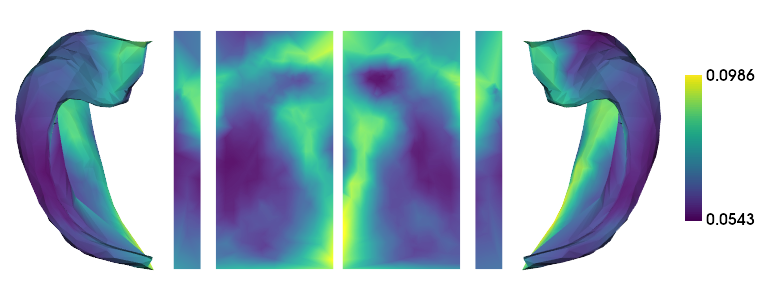

In [50]:
plotting.surfplot_canonical_foldunfold(np.nanmean(reho,axis=2), den='2mm', unfoldAPrescale=True, share='row', color_bar='right', embed_nb=True)

# 2. Intrinsic Timescale of hippocampal rsfMRI

In [34]:
cdata_hipp = np.ones((483,2,695,len(subs)))*np.nan
for s,sub in enumerate(subs):
    try:
        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                cdata_hipp[ind[l],h,:,s] = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_rsfMRI_smooth-{sigma}mm.func.gii').darrays[0].data.T[:,:695]
    except:
        print(sub)

HC098
HC113
HC061
HC006
HC104
HC117
HC114
HC062
HC021
HC111
HC110
HC107
HC071
HC070
HC004
HC051


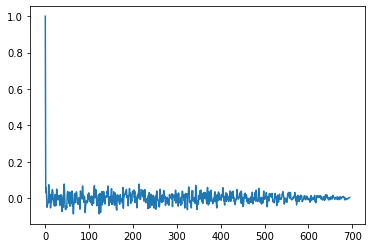

In [35]:
t = cdata_hipp[1,0,:,1]
m = np.mean(t)
var = np.var(t)
ndat = t - m
acf = np.correlate(ndat, ndat, 'full')[len(ndat)-1:] 
acf = acf / var / len(ndat)
plt.plot(acf)

In [36]:
def IntrinsicTimescale(data, TR=1, threshold=0):
    '''computes instrinsic timescale - the AUC of the autocorrelation up to the point 
    where the autocorrelation reaches threshold. 
    Input
      img: input ND data, time being the last dimension
    '''
    shp = data.shape
    i = data.reshape(-1, shp[-1])
    out = np.zeros(i.shape[0])
    for v in range(i.shape[0]):
        m = np.mean(i[v,:])
        var = np.var(i[v,:])
        ndat = i[v,:] - m
        acf = np.correlate(ndat, ndat, 'full')[len(ndat)-1:] 
        acf = acf / var / len(ndat)
        f = np.where(acf<=threshold)[0]
        if len(f)==0:
            out[v] = np.nan
        else:
            out[v] = f[0]
    out = np.reshape(out,shp[:-1])*TR
    return out

/tmp/ipykernel_21196/2710468927.py:15: RuntimeWarning: invalid value encountered in true_divide
  acf = acf / var / len(ndat)


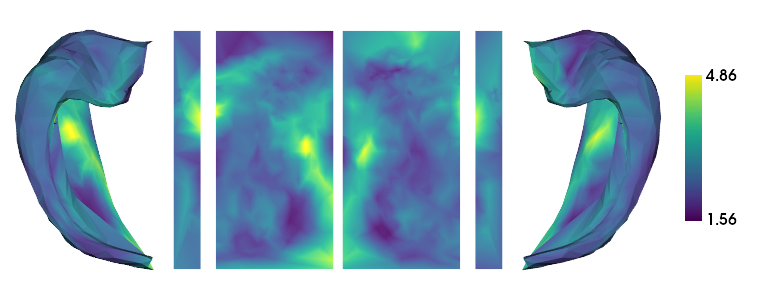

In [51]:
sub = subs[0]
TR = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-rest_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se_preproc.nii.gz').header.get_zooms()[-1]
InT = np.ones((483,2,len(subs)))*np.nan
for s,sub in enumerate(subs):
    InT[:,:,s] = IntrinsicTimescale(cdata_hipp[:,:,:,s],TR, threshold=0)
plotting.surfplot_canonical_foldunfold(np.nanmean(InT,axis=2), den='2mm', unfoldAPrescale=True, share='row', color_bar='right', embed_nb=True)

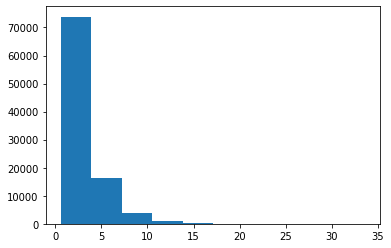

In [38]:
plt.hist(InT.flatten());

/tmp/ipykernel_21196/3135166756.py:1: RuntimeWarning: invalid value encountered in true_divide
  tSNR = np.mean(cdata_hipp,axis=2) / np.std(cdata_hipp,axis=2)


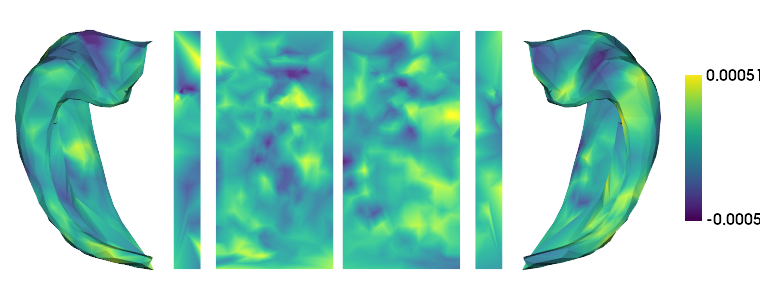

In [52]:
tSNR = np.mean(cdata_hipp,axis=2) / np.std(cdata_hipp,axis=2)
plotting.surfplot_canonical_foldunfold(np.nanmean(tSNR,axis=2), den='2mm', unfoldAPrescale=True, share='row', color_bar='right', zoom=1.7, embed_nb=True)

# 3. Functional connectivity of the hippocampus to neocortex

In [41]:
#run gradients for all subjects
FC = np.ones((483,200,2,len(subs)))*np.nan
parcL = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_lh.label.gii').darrays[0].data
parcR = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_rh.label.gii').darrays[0].data
parc = np.concatenate((parcL,parcR))

clipaftertime = 200 # in TRs. This is an approximation
for s,sub in enumerate(subs):
    try:
        neo_ts = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-rest_acq-AP_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
        neo_ts_parc = np.ones((neo_ts.shape[0],400))
        for i in range(400):
             neo_ts_parc[:,i] = np.nanmean(neo_ts[:,parc==(i+1)],axis=1)
        neo_tsL = neo_ts_parc[:,:200]   
        neo_tsR = neo_ts_parc[:,200:]
        for h,hemi in enumerate(hemis):
            ts_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_rsfMRI_smooth-{sigma}mm.func.gii').darrays[0].data
            ts_dg = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-dentate_rsfMRI_smooth-{sigma}mm.func.gii').darrays[0].data
            ts_both = np.concatenate((ts_hipp,ts_dg), axis=1)
            if hemi == 'L':
                FC[:,:,h,s] = np.corrcoef(ts_both.T,neo_tsL.T)[:483,483:]
            else:            
                FC[:,:,h,s] = np.corrcoef(ts_both.T,neo_tsR.T)[:483,483:]
    except:
        print(sub)

/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


HC098
HC113
HC061
HC006
HC104
HC117
HC114
HC062
HC021
HC111
HC110
HC107
HC071
HC070
HC004
HC051


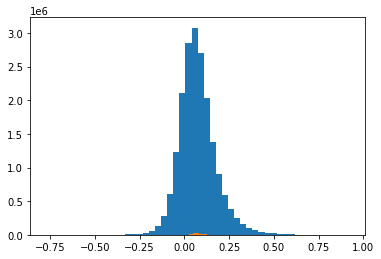

In [42]:
plt.hist(FC.flatten(),bins=50);
plt.hist(np.nanmean(FC,axis=(3)).flatten(),bins=50);

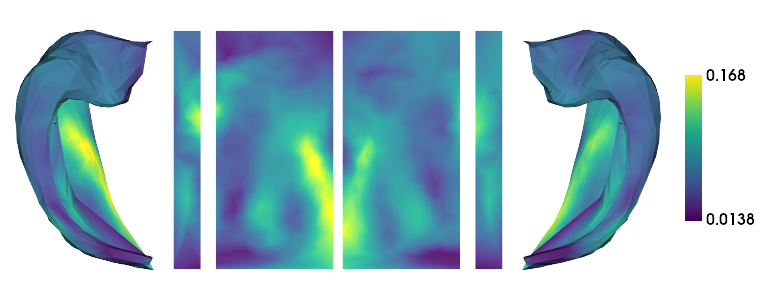

In [53]:
plotting.surfplot_canonical_foldunfold(np.nanmean(FC,axis=(1,3)), den='2mm', unfoldAPrescale=True, share='row', color_bar='right', color_range='sym', embed_nb=True)

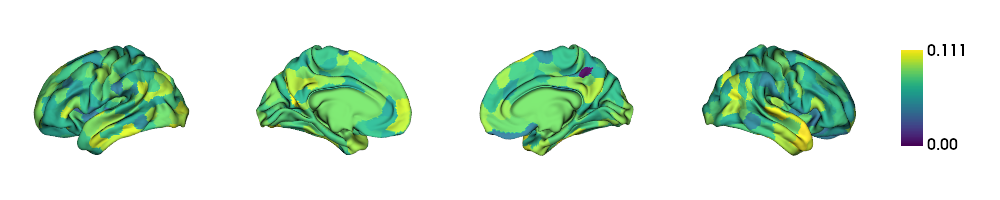

In [44]:
mc = np.zeros([surf_lh.n_points + surf_rh.n_points])
for h,hemi in enumerate(hemis):
    for i in range(200):
        mc[parc==(i+(h*200))] = np.nanmean(FC[:,i,h,:],axis=(0,1))

plot_hemispheres(surf_lh, surf_rh, array_name=np.hsplit(mc,1), 
                 size=(1000, 200), color_bar=True, embed_nb=True)

# 4. Gradients of differential hippocampal FC

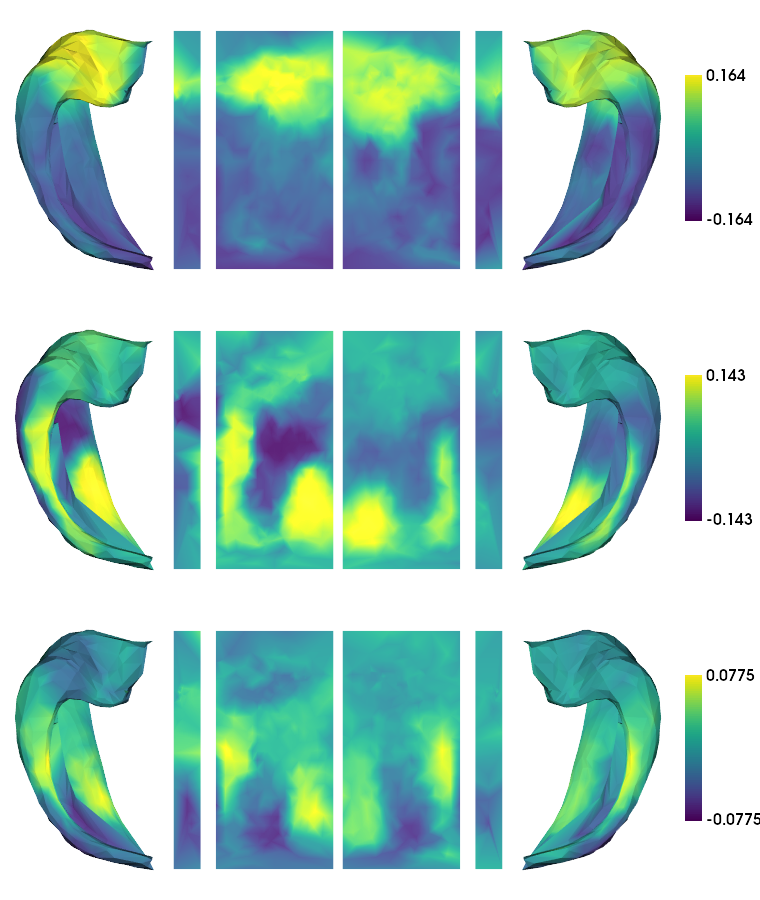

In [54]:
ngrads = 3
gradients = np.zeros((483,2,ngrads))
for h,hemi in enumerate(hemis):
    gm = GradientMaps(n_components=ngrads, kernel='normalized_angle', random_state=0, alignment='procrustes')
    gm.fit(np.nanmean(FC[:,:,h,:],axis=(2)))
    gradients[:,h,:] = gm.gradients_
    
# manually flip any L-R mismatch
gradients[:,1,0] = -gradients[:,1,0]
plotting.surfplot_canonical_foldunfold(gradients, den='2mm', unfoldAPrescale=True, share='row', color_bar='right', color_range='sym', embed_nb=True)

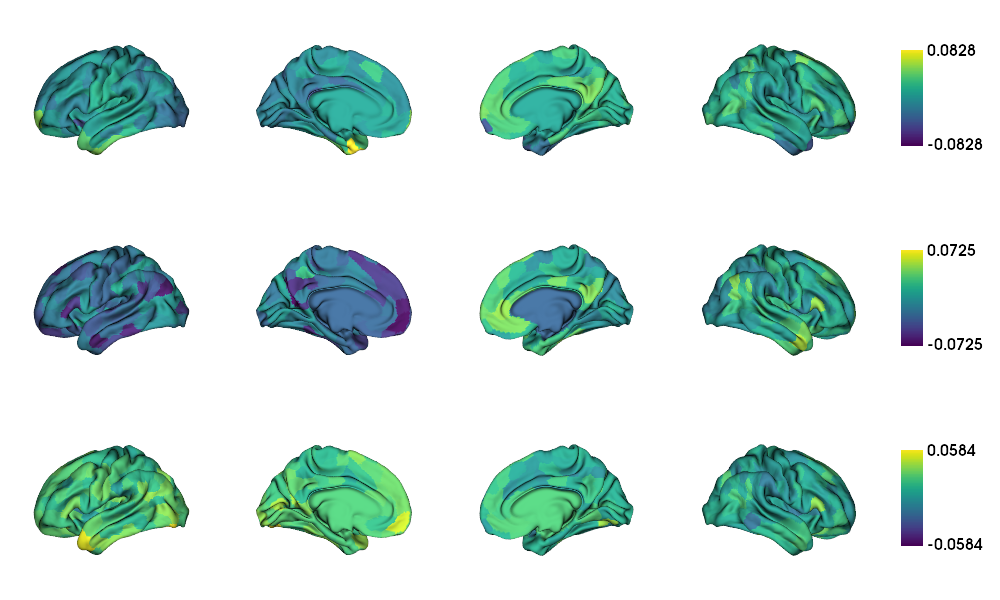

In [46]:
# look only at FC to the rest of the neocortex for the top-bottom 10% of each gradient
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.utils.parcellation import map_to_labels
from brainspace.plotting import plot_hemispheres

surf_lh, surf_rh = load_conte69()

nverts = 483
nvertsplit = int(nverts*.25)

diffval = np.zeros([surf_lh.n_points + surf_rh.n_points,ngrads])
botval = np.zeros(surf_lh.n_points + surf_rh.n_points)
topval = np.zeros(surf_lh.n_points + surf_rh.n_points)
for g in range(ngrads):
    for h,hemi in enumerate(hemis):
        bot = np.argpartition(gradients[:,h,g],nvertsplit)[:nvertsplit]
        top = np.argpartition(gradients[:,h,g],-nvertsplit)[-nvertsplit:]
        for i in range(200):
            botval[parc==(i+(h*200))] = np.nanmean(FC[bot,i,h,:],axis=(0,1))
            topval[parc==(i+(h*200))] = np.nanmean(FC[top,i,h,:],axis=(0,1))
        diffval[:,g] = topval-botval

plot_hemispheres(surf_lh, surf_rh, array_name=np.hsplit(diffval,ngrads), 
                 size=(1000, 200*ngrads), color_bar=True, embed_nb=True, color_range='sym')